# In this tutorial we demonstrate how to check if values are significantly different from each other using t-tests

In [33]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#### Open events data

In [34]:
#open events data
path = os.path.join(str(pathlib.Path().resolve()),  'Wyscout', 'events_England.json')
with open(path) as f:
    events = json.load(f)

events_df = pd.DataFrame(events)


#### Open teams data

In [35]:

#open team data
path = os.path.join(str(pathlib.Path().resolve()),'Wyscout', 'teams.json')
with open(path) as f:
    teams = json.load(f)

teams_df = pd.DataFrame(teams)
teams_df = teams_df.rename(columns={"wyId": "teamId"})

#### Get corners per team per match.

In [36]:
#get corners
corners = events_df.loc[events_df["subEventName"] == "Corner"]
#count corners by team
corners_by_team = corners.groupby(['teamId']).size().reset_index(name='counts')
#merge with team name
summary = corners_by_team.merge(teams_df[["name", "teamId"]], how = "left", on = ["teamId"])
#count corners by team by game
corners_by_game = corners.groupby(['teamId', "matchId"]).size().reset_index(name='counts')
#merge with team name
summary2 = corners_by_game.merge(teams_df[["name", "teamId"]], how = "left", on = ["teamId"])

In [37]:
# Calculate the mean of the 'counts' column in summary2
mean_corners = summary2["counts"].mean()

# Calculate the standard deviation of the 'counts' column in summary2
std_corners = summary2["counts"].std()

# Print the results
print(f"Mean number of corners: {mean_corners:.2f}")
print(f"Standard deviation of corners: {std_corners:.2f}")


Mean number of corners: 5.26
Standard deviation of corners: 2.88


### One-sample one-sided t-test.  
#### According to the mean value teams typically get 5 corners in a match in football.  
#### City are an attacking team and we might think that they get more corners than this.  
#### Let’s start by plotting a distribution of City’s corners.

City typically had 7.50  plus/minus 3.28 corners per match in the 2017/18 season.


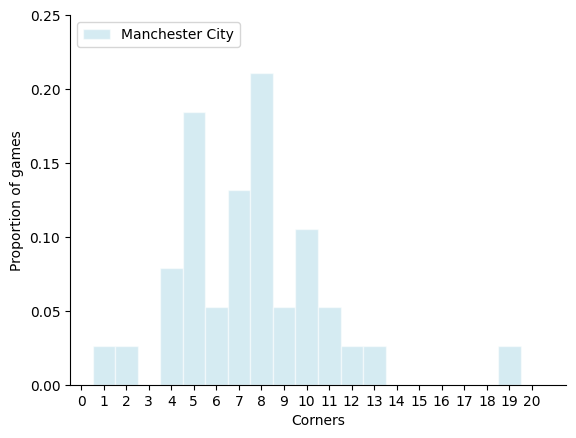

In [38]:
team_name= 'Manchester City'

city_corners = summary2.loc[summary2["name"] == 'Manchester City']["counts"]

def FormatFigure(ax):
    ax.legend(loc='upper left')
    ax.set_ylim(0,0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('Corners')
    ax.set_ylabel('Proportion of games')
    ax.set_xticks(np.arange(0,21,step=1))


fig,ax1=plt.subplots(1,1)
ax1.hist(city_corners, np.arange(0.01,20.5,1), color='lightblue', edgecolor = 'white',linestyle='-',alpha=0.5, label=team_name, density=True,align='right')
FormatFigure(ax1)


mean = city_corners.mean()
std = city_corners.std()

print('City typically had %.2f  plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))

## Check Normal Distribution  
#### A. Histogram and KDE Plot (with normal curve overlay)  
You can plot a histogram with a kernel density estimate (KDE) and overlay a normal distribution curve to visually inspect how well the data fits a normal distribution.

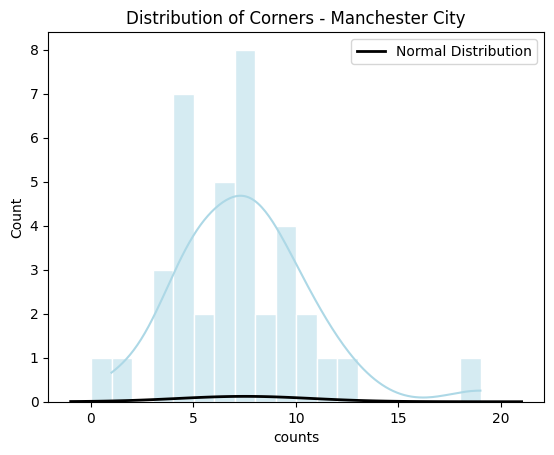

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot Histogram and KDE
sns.histplot(city_corners, bins=np.arange(0.01, 20.5, 1), kde=True, color='lightblue', edgecolor='white', alpha=0.5)

# Overlay the normal distribution curve with same mean and std as city_corners
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, city_corners.mean(), city_corners.std())
plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution")

# Customize plot
plt.title(f"Distribution of Corners - {team_name}")
plt.legend()
plt.show()


## B. Q-Q Plot (Quantile-Quantile Plot):  
A Q-Q plot compares the quantiles of your data to the quantiles of a theoretical normal distribution. If the data follows a normal distribution, the points will approximately fall along a straight line.

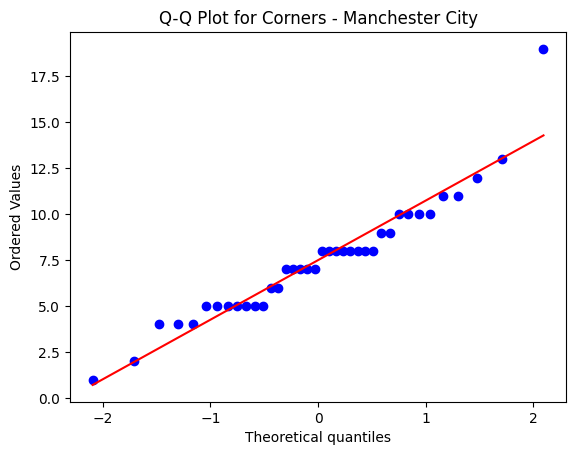

In [40]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q-Q plot to check normality
stats.probplot(city_corners, dist="norm", plot=plt)
plt.title(f"Q-Q Plot for Corners - {team_name}")
plt.show()


## Statistical Tests for Normality:  
A. Shapiro-Wilk Test:
The Shapiro-Wilk test is one of the most common statistical tests to check for normality. The null hypothesis is that the data is normally distributed.

In [41]:
from scipy.stats import shapiro

# Shapiro-Wilk test
stat, p_value = shapiro(city_corners)

print(f'Statistic: {stat}, P-value: {p_value}')

if p_value > 0.05:
    print(f'The data likely follows a normal distribution (fail to reject H0, P-value: {p_value:.5f})')
else:
    print(f'The data likely does NOT follow a normal distribution (reject H0, P-value: {p_value:.5f})')


Statistic: 0.9324438468032399, P-value: 0.023965941198058473
The data likely does NOT follow a normal distribution (reject H0, P-value: 0.02397)


## B. D'Agostino's K-squared Test:  
Another test for normality is D’Agostino’s K-squared test, which tests whether the skewness and kurtosis of the distribution match a normal distribution.

In [42]:
from scipy.stats import normaltest

# D'Agostino and Pearson's test
stat, p_value = normaltest(city_corners)

print(f'Statistic: {stat}, P-value: {p_value}')

if p_value > 0.05:
    print(f'The data likely follows a normal distribution (fail to reject H0, P-value: {p_value:.5f})')
else:
    print(f'The data likely does NOT follow a normal distribution (reject H0, P-value: {p_value:.5f})')


Statistic: 12.69591094856515, P-value: 0.0017503220589684596
The data likely does NOT follow a normal distribution (reject H0, P-value: 0.00175)


#### Since the above statistical tests do not justify that city_corners follow a normal distribution we need to check tha sample size.  
#### According to the Central Limit Theorem a sufficiently large sample size (usually 𝑛>30) indicateds that the sampling distribution of the sample mean tends to be normally distributed, even if the underlying data is not perfectly normal.

In [43]:
num_rows = len(city_corners)
print(f"Number of rows in city_corners: {num_rows}")


Number of rows in city_corners: 38


Since the sample is 38 We use can use a one-sided t-test to check if Manchester City took more corners than we might expect due to normal variation in the number of corners we tend to see.  
We set the significance level at 0.05.

In [49]:
from scipy.stats import ttest_1samp
t, pvalue = ttest_1samp(city_corners,popmean=5)

print("The t-staistic is %.2f and the P-value is %.2f."%(t,pvalue))
if pvalue < 0.05:
    print("We reject null hypothesis - " + team_name + " typically take more than 5 corners per match.")
else:
    print("We cannot reject null hypothesis - " + team_name + " do not typically take more than 5 corners per match.")

The t-staistic is 4.70 and the P-value is 0.00.
We reject null hypothesis - Manchester City typically take more than 5 corners per match.


# Two-sample two-sided t-test  
#### Here we compare Liverpool and Everton in terms of corners per match.

In [45]:
liverpool_corners = summary2.loc[summary2["name"] == 'Liverpool']["counts"]
everton_corners = summary2.loc[summary2["name"] == 'Everton']["counts"]

mean = liverpool_corners.mean()
std = liverpool_corners.std()
print('Liverpool typically had %.2f plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))
std_error=std/np.sqrt(len(liverpool_corners))
print('The standard error in the number of corners per match is %.4f'%std_error)

mean = everton_corners.mean()
std = everton_corners.std()
print('Everton typically had %.2f plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))
std_error=std/np.sqrt(len(everton_corners))
print('The standard error in the number of corners per match is %.4f'%std_error)

Liverpool typically had 6.08 plus/minus 3.06 corners per match in the 2017/18 season.
The standard error in the number of corners per match is 0.4966
Everton typically had 4.17 plus/minus 2.66 corners per match in the 2017/18 season.
The standard error in the number of corners per match is 0.4428


#### Now let’s plot the corners as a histogram.

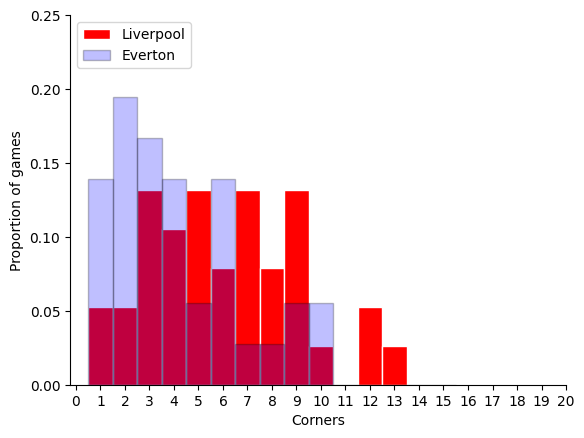

In [46]:
fig,ax=plt.subplots(1,1)
ax.hist(liverpool_corners, np.arange(0.01,15.5,1), color='red', edgecolor = 'white',linestyle='-',alpha=1.0, label="Liverpool", density=True,align='right')
ax.hist(everton_corners, np.arange(0.01,15.5,1), alpha=0.25, color='blue', edgecolor = 'black', label='Everton',  density=True,align='right')
FormatFigure(ax)

#### Run Levene's test to check samples' variances.

In [47]:
from scipy.stats import levene

# Perform Levene's test for equality of variances
stat, pvalue = levene(liverpool_corners, everton_corners)

print(f"Levene’s test statistic: {stat}")
print(f"P-value: {pvalue}")


Levene’s test statistic: 0.9492667936471965
P-value: 0.3331680800430855


#### Here we test if Liverpool had a different average corners per game than Everton.
#### We set the significance level at 0.05.

In [48]:



from scipy.stats import ttest_ind
t, pvalue  = ttest_ind(a=liverpool_corners, b=everton_corners, equal_var=True)

print("The t-staistic is %.2f and the P-value is %.2f."%(t,pvalue))
if pvalue < 0.05:
    print("We reject null hypothesis - Liverpool took different number of corners per game than Everton")
else:
    print("We cannot reject the null hypothesis that Liverpool took the same number of corners per game as Everton")

The t-staistic is 2.86 and the P-value is 0.01.
We reject null hypothesis - Liverpool took different number of corners per game than Everton
